# 使用PyTorch训练神经网络

我们将展示使用PyTorch搭建并训练一个神经网络的标准流程。

最主要的流程是以下三个部分。

1. 构建数据集
2. 搭建网络
3. 训练网络

不过，首先，我们要先import需要用到的包

In [1]:
import math
import torch
import matplotlib.pyplot as plt
from torch import nn

## 构建数据集

我们选取的训练数据是$[-\pi,\pi]$上的sin函数，并且增加一点噪声。

torch.Size([1000, 1]) torch.Size([1000, 1])


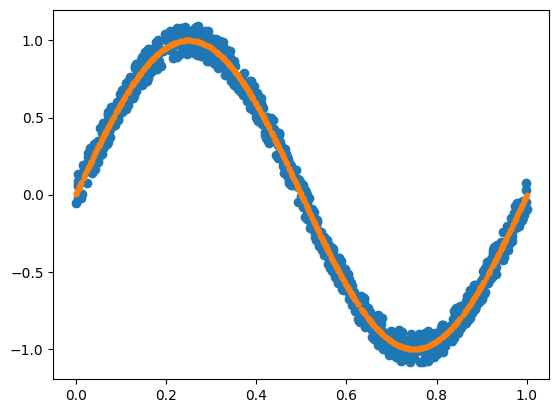

In [51]:
N=1000
x_train = torch.rand((N,1))
y_train = torch.sin(2*math.pi*x_train)+(torch.rand((N,1))-0.5)*0.2

x_valid = torch.rand((N,1))
y_valid = torch.sin(2*math.pi*x_valid)

print(x_train.shape,y_train.shape)
plt.scatter(x_train,y_train)
plt.scatter(x_valid,y_valid,marker='.')

这样的数据一般来说，并不适合直接用来训练神经网络。因为有时候数据集太大，我们希望每次喂入网络一点，然后通过SGD这类方法进行优化。所以我们使用Pytorch的torch.utils.data下的dataset和dataloader工具进行封装

### 使用torch.utils.data封装数据集

因为数据类型就是Tensor，所以我们使用torch.utils.data.TensorDataset封装数据集。
然后我们可以看一下，得到的dataset就像一个list一样可以进行随机访问。

In [52]:
train_dataset=torch.utils.data.TensorDataset(x_train,y_train)
valid_dataset=torch.utils.data.TensorDataset(x_valid,y_valid)
print(train_dataset[0:2])

(tensor([[0.6265],
        [0.2779]]), tensor([[-0.8071],
        [ 0.9642]]))


### 使用torch.utils.data封装数据加载器

封装数据集后，我们还需要得到dataloader，它负责从dataloader中根据batchsize选择sample构建minibatch。是否随机采样也是在这一步完成的。

In [56]:
train_dataloader=torch.utils.data.DataLoader(train_dataset,batch_size=64,shuffle=True,num_workers=2)
valid_dataloader=torch.utils.data.DataLoader(valid_dataset,batch_size=64,shuffle=False,num_workers=2)

## 搭建网络

这里我们使用一个全连接网络来进行学习

In [57]:
class FullyConnectedNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1=nn.Linear(1,32)
        self.act1=nn.ReLU()
        self.fc2=nn.Linear(32,32)
        self.act2=nn.ReLU()
        self.fc3=nn.Linear(32,32)
        self.act3=nn.ReLU()
        self.fc4=nn.Linear(32,1)
    def forward(self,x):
        x=self.fc1(x)
        x=self.act1(x)
        x=self.fc2(x)
        x=self.act2(x)
        x=self.fc3(x)
        x=self.act3(x)
        x=self.fc4(x)
        return x
        
my_nn = FullyConnectedNet()

`我们尝试一下搭建好的网络输入x后，输出是什么样的

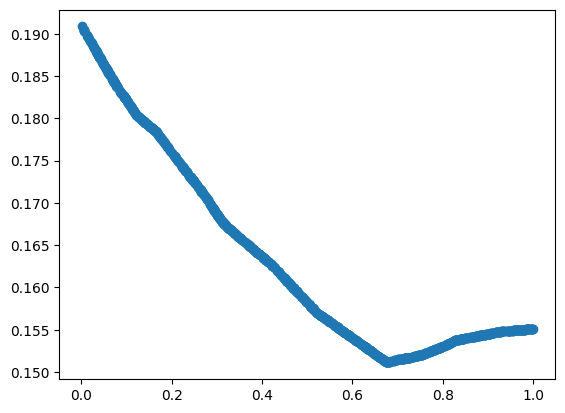

In [58]:
y_pred=my_nn(x_train)
plt.scatter(x_train,y_pred.detach())

## 训练网络

In [59]:
optimizer=torch.optim.Adam( my_nn.parameters(), lr=1e-3)
scheduler=torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer,100,2)
epochs=100

train_loss_hist=[]
valid_loss_hist=[]
for i in range(1,1+epochs):
    train_loss=0
    for x,y in train_dataloader:
        y_pred=my_nn(x)
        loss=(y_pred-y).square().mean()
        train_loss+=loss.item()
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    train_loss_hist.append(train_loss)   
    scheduler.step()
    
    valid_loss=0
    for x,y in valid_dataloader:
        y_pred=my_nn(x)
        loss=(y_pred-y).square().mean()
        valid_loss+=loss.item()
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    valid_loss_hist.append(valid_loss)  
        
    if i%10==0:
        print(f"epoch:{i}, train loss: {train_loss}, valid loss: {valid_loss}")

epoch:50, train loss: 0.05644382582977414, valid loss: 0.0034369534259894863
epoch:100, train loss: 0.05306869884952903, valid loss: 0.0015230389399221167


## 可视化训练结果

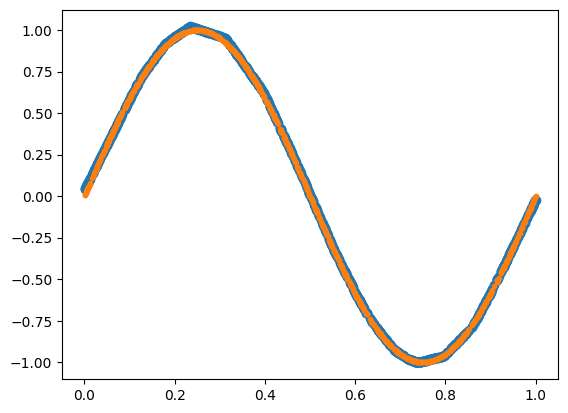

In [65]:
plt.scatter(x_valid,my_nn(x_valid).detach())
plt.scatter(x_valid,y_valid,marker=".")